# Create train-test-validation splits

## For promiscuous esterases

### MMSeqs2 with 50% and 30% sequence similarity

In [13]:
import sys
sys.path.append('/home/helen/enzyme-tk/enzymetk')
from enzymetk.similarity_mmseqs_step import MMseqs
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environment
df_promis_esterases = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_short_seq_removed.pkl')
df_promis_esterases.rename(columns={'mmseqs_representative_cluster_seq': 'mmseqs_representative_cluster_seq_0.95'}, inplace=True)
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'mmseqs2/'

df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.5', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_removed_similar_seq_0p5_similarity.pkl'))
df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.3', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_removed_similar_seq_0p3_similarity.pkl'))

--------------------------------------------------------------------------------
Running command	mmseqs easy-cluster mmseqs2//seqs.fasta mmseqs2//clusterRes mmseqs2//tmp --min-seq-id 0.5 -c 0.8 --cov-mode 1	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------
easy-cluster mmseqs2//seqs.fasta mmseqs2//clusterRes mmseqs2//tmp --min-seq-id 0.5 -c 0.8 --cov-mode 1 

MMseqs Version:                     	17.b804f
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof

,UniprotID,RHEA_ID,DIRECTION,MASTER_ID,SMILES,EC number,CANO_RXN_SMILES,sequence,reverse_template,n_seq,...,rank_weight_light,rank_weight_hard,substrates,products,number_substrates,number_products,atom_mapped_SMILES,cleaved_substrate,mmseqs2_clusters_0p95_similarity,mmseqs_representative_cluster_seq
0,A0A0G2JXT6,45632,UN,45632,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,3.1.3.95,CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,0.6,0.200000,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@H]1[C@H](...,2,2,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,A0A0G2JXT6,Q96EF0
1,A0A0G2JXT6,39019,UN,39019,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...,3.1.3.95,*C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,0.5,0.142857,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@H]1[C@H](O)...,2,2,[*:1][C:2](=[O:3])[O:4][CH2:5][C@H:6]([CH2:7][...,*C(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H](O)[C@...,A0A0G2JXT6,Q96EF0
2,A0A0G2JXT6,12316,UN,12316,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...,3.1.3.95,*C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,0.5,0.125000,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...,*C(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H](O)[C@...,2,2,[*:1][C:2](=[O:3])[O:4][CH2:5][C@H:6]([CH2:7][...,*C(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H](O)[C@...,A0A0G2JXT6,Q96EF0
3,A0A0G2JXT6,42328,UN,42328,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,3.1.3.95,CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,0.8,0.333333,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,2,2,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,A0A0G2JXT6,Q96EF0
4,A0A0H2V660,60392,UN,60392,[H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...,3.1.1.109,O.O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O...,MIDKNQTCGVGQDSVPYMICLIHILEEWFGVEQLEDYLNFANYLLW...,[#7:1]-[C:2](-[CH2;D2;+0:3]-[OH;D1;+0:10])-[C:...,324,...,1.0,1.000000,[H][C@]12COC(=O)[C@]3([H])COC(=O)[C@]([H])(COC...,O=C1N[C@H](C(=O)[O-])COC(=O)[C@@H]2COC(=O)[C@H...,2,2,[OH2:7].[O:1]=[C:2]1[NH:3][C@@H:4]2[C:5](=[O:6...,O=C1N[C@H]2COC(=O)[C@@H]3COC(=O)[C@H](COC2=O)N...,A0A0H2V660,A0A0H2V660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4880,V6CIV8,10684,UN,10684,*N[C@@H](CC1=CC=C(OP(=O)([O-])[O-])C=C1)C(*)=O,3.1.3.16; 3.1.3.48,*N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(*)=O.O>>*N[C@...,MTTHLPSTSQNGEEISAEQFNRIFHERNVIVLDCRSNGDSVKRANR...,[O-;H0;D1:7]-[P;H0;D4;+0:2](-[O;-;D1;H0:3])(=[...,381,...,NaN,NaN,*N[C@@H](CC1=CC=C(OP(=O)([O-])[O-])C=C1)C(*)=O...,*N[C@@H](CC1=CC=C(O)C=C1)C(*)=O.O=P([O-])([O-])O,2,2,[*:1][NH:2][C@@H:3]([CH2:4][c:5]1[cH:6][cH:7][...,*N[C@@H](Cc1ccc(OP(=O)([O-])[O-])cc1)C(*)=O,V6CIV8,Q91Z46
4881,V6CIV8,20629,UN,20629,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,3.1.3.16; 3.1.3.48,*N[C@@H](COP(=O)(O)O)C(*)=O.O>>*N[C@@H](CO)C(*...,MTTHLPSTSQNGEEISAEQFNRIFHERNVIVLDCRSNGDSVKRANR...,NaN,381,...,0.7,0.250000,*N[C@@H](COP(=O)([O-])[O-])C(*)=O.[H]O[H],*N[C@@H](CO)C(*)=O.O=P([O-])([O-])O,2,2,[*:1][NH:2][C@@H:3]([CH2:4][O:5][P:10](=[O:9])...,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,V6CIV8,Q91Z46
4882,V6CIV8,47004,UN,47004,*N[C@H](C(*)=O)[C@@H](C)OP(=O)([O-])[O-],3.1.3.16; 3.1.3.48,*N[C@H](C(*)=O)[C@@H](C)OP(=O)(O)O.O>>*N[C@H](...,MTTHLPSTSQNGEEISAEQFNRIFHERNVIVLDCRSNGDSVKRANR...,[C:1]-[OH;D1;+0:2].[O-;H0;D1:7]-[P;H0;D4;+0:3]...,381,...,1.0,1.000000,*N[C@H](C(*)=O)[C@@H](C)OP(=O)([O-])[O-].[H]O[H],*N[C@H](C(*)=O)[C@@H](C)O.O=P([O-])([O-])O,2

In [3]:
# Integrate mmseqs2 results into one df
import pandas as pd

df_mmseqs2_0p5 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_removed_similar_seq_0p5_similarity.pkl')
df_mmseqs2_0p3 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_removed_similar_seq_0p3_similarity.pkl')

df_mmseqs2_0p5 = df_mmseqs2_0p5.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p5_similarity'})
df_mmseqs2_0p3 = df_mmseqs2_0p3.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p3_similarity'})

# Keep only one representative cluster per UniprotID for merge purposes
df_mmseqs2_0p3_dedup = df_mmseqs2_0p3.drop_duplicates(subset='UniprotID')

df = df_mmseqs2_0p5.merge(
    df_mmseqs2_0p3_dedup[['UniprotID', 'mmseqs_representative_cluster_seq_0p3_similarity']],
    on='UniprotID', how='left')


### Held-out set based on substrate similarity (with tanomioto similarity)

Can the model predict function for enzymes that act on substrates unseen or dissimilar to those in training?

In [4]:
# Calculate morgan fingerprints for cleaved substrates 

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import ConvertToNumpyArray
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)

def get_morgan_fingerprint(smiles):
    if not isinstance(smiles, str) or not smiles.strip():
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return morgan_generator.GetFingerprint(mol) 
    return None

# Get unique substrates and their morgan fingerprints
unique_substrates_df = df[['cleaved_substrate']].drop_duplicates().copy()
unique_substrates_df['fingerprint'] = unique_substrates_df['cleaved_substrate'].apply(get_morgan_fingerprint)
unique_substrates_df = unique_substrates_df.dropna(subset=['fingerprint']) # Remove any SMILES that RDKit couldn't parse


In [5]:
# Compute Tanimoto similarity between all unique substrate fingerprints

substrate_fps = list(unique_substrates_df['fingerprint'])
fp_to_smiles = dict(zip(unique_substrates_df.index, unique_substrates_df['cleaved_substrate']))

n_substrates = len(substrate_fps)
substrate_similarity_matrix = np.zeros((n_substrates, n_substrates))

for i in range(n_substrates):
    for j in range(i, n_substrates):
        sim = DataStructs.TanimotoSimilarity(substrate_fps[i], substrate_fps[j])
        substrate_similarity_matrix[i, j] = sim
        substrate_similarity_matrix[j, i] = sim

# Convert similarity to distance for clustering
substrate_distance_matrix = 1 - substrate_similarity_matrix

In [35]:
# Cluster substrates using Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(
    n_clusters=None, 
    distance_threshold=0.7, # Group substrates with Tanimoto similarity >= 0.5
    metric='precomputed',
    linkage='average' 
)

unique_substrates_df['substrate_cluster'] = agg_clustering.fit_predict(substrate_distance_matrix)

n_clusters = len(np.unique(unique_substrates_df['substrate_cluster']))
print(f"Number of clusters: {n_clusters}")


Number of clusters: 47


/tmp/ipykernel_1685885/1277673269.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('turbo', num_clusters)
/tmp/ipykernel_1685885/1277673269.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


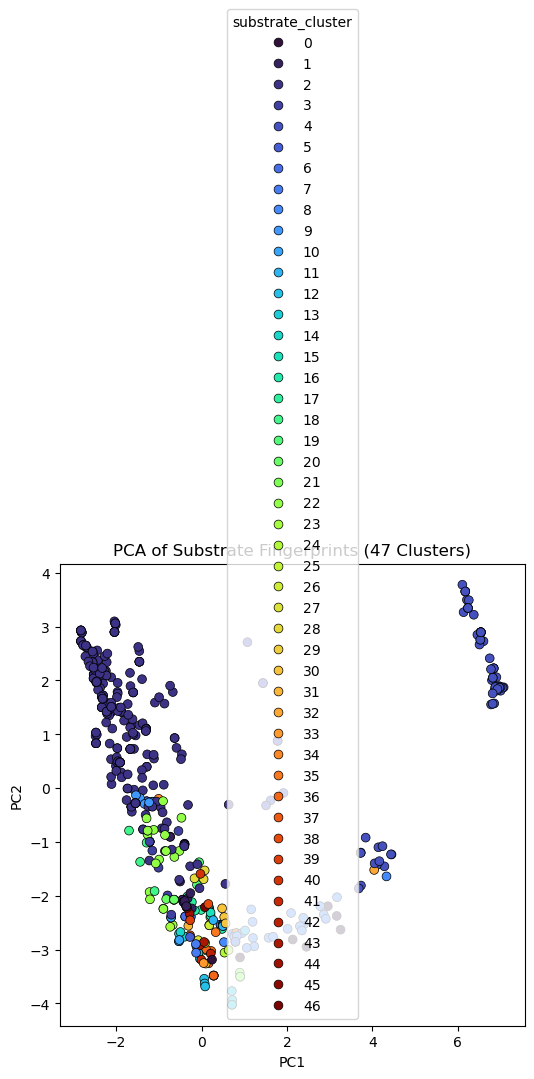

In [ ]:
# PCA visualization of substrate clustering 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Prepare fingerprint matrix
fps = [np.array(list(fp.ToBitString()), dtype=int) for fp in unique_substrates_df['fingerprint']]
fps_matrix = np.array(fps)

# Apply PCA
pca = PCA(n_components=2)
fps_2d = pca.fit_transform(fps_matrix)

# Define color palette
num_clusters = unique_substrates_df['substrate_cluster'].nunique()
norm = mcolors.Normalize(vmin=0, vmax=num_clusters - 1)
cmap = cm.get_cmap('turbo', num_clusters)
palette = [cmap(norm(i)) for i in range(num_clusters)]

# Plot with clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=fps_2d[:, 0],
    y=fps_2d[:, 1],
    hue=unique_substrates_df['substrate_cluster'],
    palette=palette,
    s=40,
    edgecolor='k', 
    legend = True
)
plt.title(f"PCA of Substrate Fingerprints ({n_clusters} Clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


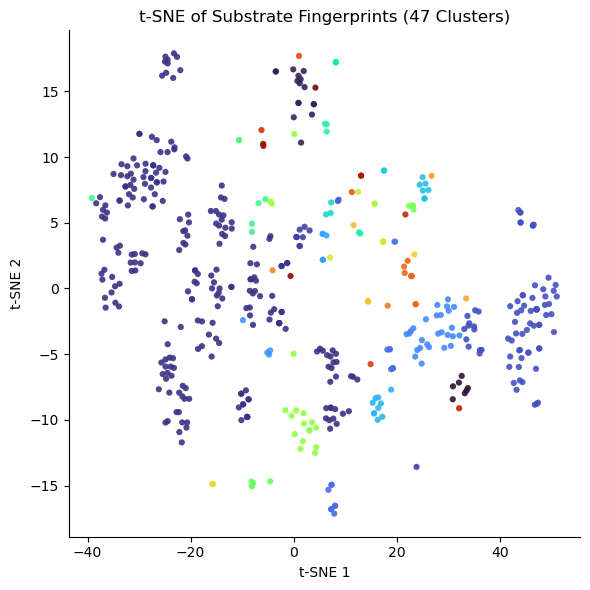

In [ ]:
# t-SNE visualization of substrate clustering # 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

fingerprint_matrix = np.array([np.array(fp) for fp in unique_substrates_df['fingerprint']])

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, metric='cosine')
tsne_results = tsne.fit_transform(fingerprint_matrix)

# Add t-SNE results to the dataframe
unique_substrates_df['tsne-2d-one'] = tsne_results[:,0]
unique_substrates_df['tsne-2d-two'] = tsne_results[:,1]

# Plot
plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="substrate_cluster",
    palette=palette,
    data=unique_substrates_df,
    s=20,  # point size
    linewidth=0,
    alpha=0.9,
    legend=False  # Set to True if you want legend
)
plt.title(f"t-SNE of Substrate Fingerprints ({n_clusters} Clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
sns.despine()
plt.tight_layout()
plt.show()


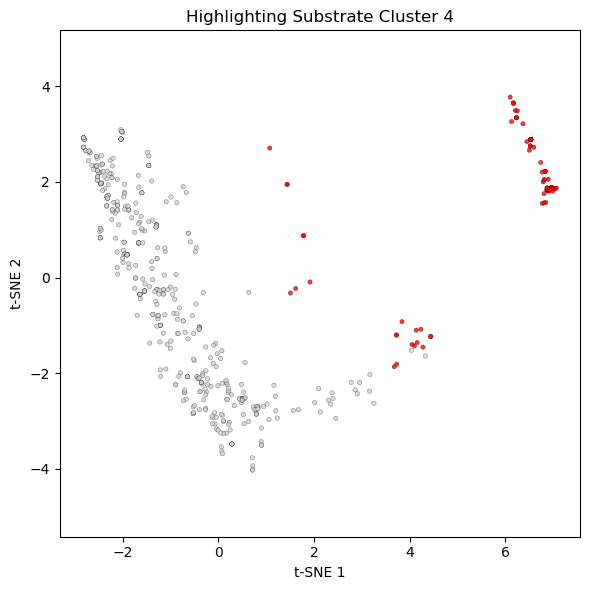

SMILES strings in cluster 4:
54      CCCCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C...
109     CCCCCCCC/C=C\CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H...
110     CCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C...
111     CCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)CO...
113     CCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)...
                              ...                        
4639    CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O...
4641    CCCCCCCCCCCCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[...
4645    CCCCCCCCCCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)[C@...
4875    CC(C)CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP...
4876    CCC(C)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP...
Name: cleaved_substrate, Length: 76, dtype: object


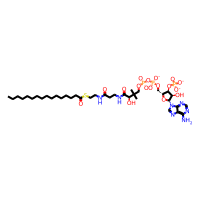

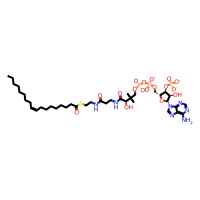

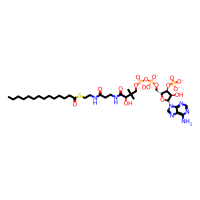

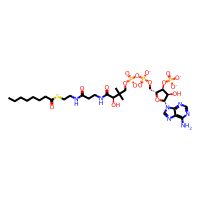

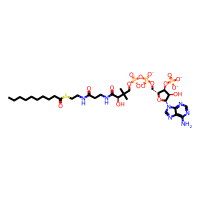

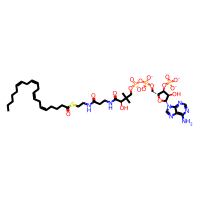

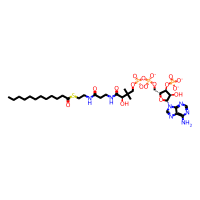

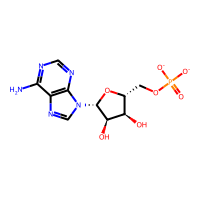

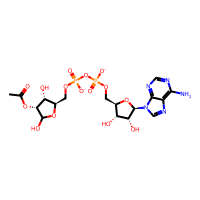

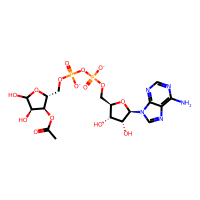

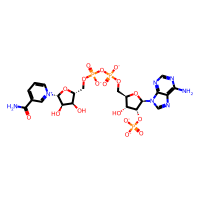

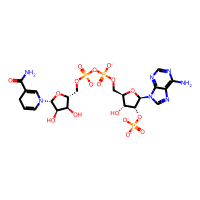

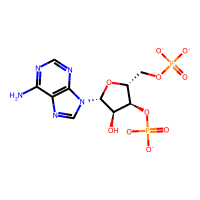

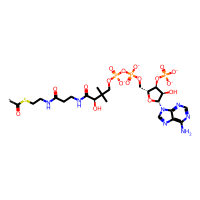

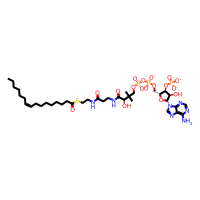

In [55]:
# Investigate outlier substrate cluster

import matplotlib.pyplot as plt
import seaborn as sns

# Your t-SNE or PCA coordinates
x = fps_2d[:, 0]
y = fps_2d[:, 1]
cluster_ids = unique_substrates_df['substrate_cluster']

# Define the cluster you want to highlight
target_cluster_id = 4  # Replace with the cluster ID you want to color
highlight_color = 'red'
other_color = 'lightgray'

# Create color list based on cluster membership
colors = [highlight_color if cid == target_cluster_id else other_color for cid in cluster_ids]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=colors, s=10, alpha=0.8, edgecolors='k', linewidth=0.2)
plt.title(f"Highlighting Substrate Cluster {target_cluster_id}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Filter the rows that belong to this cluster
cluster_smiles = unique_substrates_df.loc[
    unique_substrates_df['substrate_cluster'] == target_cluster_id, 
    'cleaved_substrate'
]

# Display results
print(f"SMILES strings in cluster {target_cluster_id}:")
print(cluster_smiles)


from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

smiles_list = cluster_smiles.tolist() 
smiles_list = smiles_list[0:15]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list if smi is not None]

for mol in mols:
    img = Draw.MolToImage(mol, size=(200, 200))
    display(img)




In [ ]:
# Select held-out cluster samples

# Select held-out substrate cluster(s)


chosen_held_out_cluster_id = unique_substrates_df['substrate_cluster'].value_counts().idxmin() # Pick the smallest cluster for holding out 
# You could also pick by specific SMILES:
# chosen_held_out_smiles = ['ClCCCl', 'BrCCBr']
# held_out_smiles = [s for s in chosen_held_out_smiles if s in unique_substrates_df['substrate_smiles'].tolist()]

held_out_smiles = unique_substrates_df[unique_substrates_df['substrate_cluster'] == chosen_held_out_cluster_id]['cleaved_substrate'].tolist()
print(f"\nChosen held-out substrate cluster ID: {chosen_held_out_cluster_id}")
print(f"Substrates in held-out set: {held_out_smiles}")

# Form Held-Out Set & Remove from Main Data

### Split into train-test sets

In [10]:
# Create training and 50% and 30% test sets

import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique 50% clusters
clusters_50 = df_mmseqs2['mmseqs_representative_cluster_seq_0p5_similarity'].unique()
train_clusters_50, test_clusters_50 = train_test_split(
    clusters_50, test_size=0.2, random_state=42
)

# Create 50% identity split
train_50 = df_mmseqs2[df_mmseqs2['mmseqs_representative_cluster_seq_0p5_similarity'].isin(train_clusters_50)]
test_50 = df_mmseqs2[df_mmseqs2['mmseqs_representative_cluster_seq_0p5_similarity'].isin(test_clusters_50)]

# Identify 30% clusters within the 50% test set
test_50_clusters_30 = test_50['mmseqs_representative_cluster_seq_0p3_similarity'].unique()

# Important: Only keep 30% clusters that are *not present* in 50% training set
train_50_clusters_30 = train_50['mmseqs_representative_cluster_seq_0p3_similarity'].unique()
strict_test_clusters_30 = set(test_50_clusters_30) - set(train_50_clusters_30)

# Filter test_50 to get test_30
test_30 = test_50[test_50['mmseqs_representative_cluster_seq_0p3_similarity'].isin(strict_test_clusters_30)]


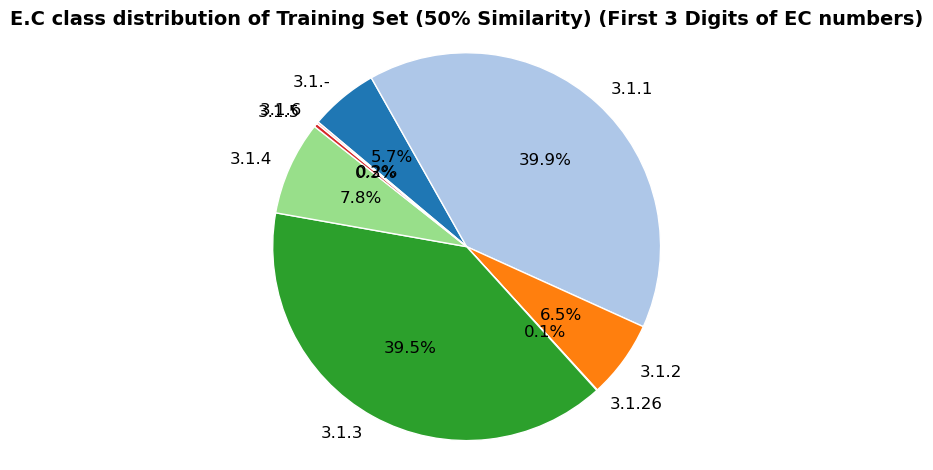

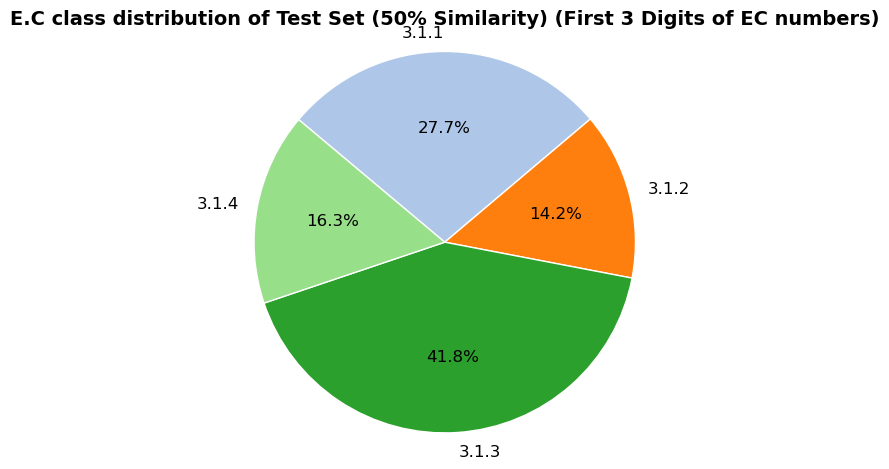

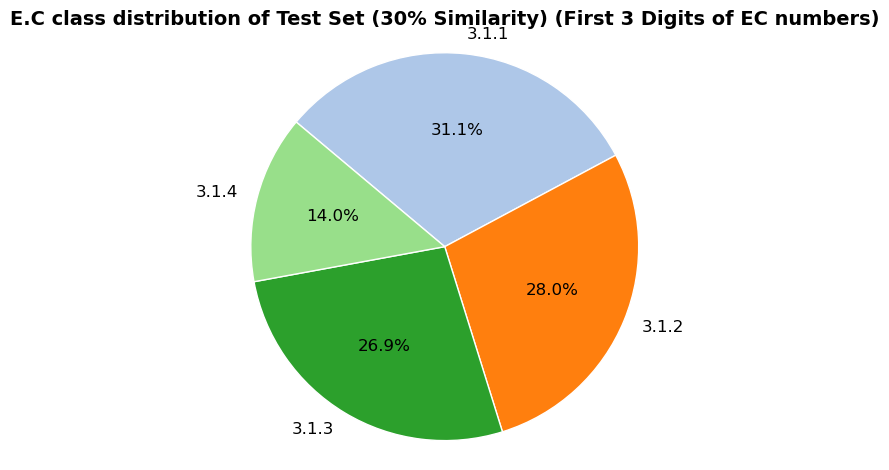

In [20]:
# Plot pie-charts of EC class distribution

# Combine both DataFrames to find all unique EC classes
combined_df = pd.concat([train_50, test_50])
combined_df = combined_df[combined_df['EC number'].notna()]
combined_df['EC_prefix'] = combined_df['EC number'].apply(
    lambda x: '.'.join(x.split('.')[:3]) if isinstance(x, str) else None
)
all_ec_classes = sorted(combined_df['EC_prefix'].dropna().unique())

# Create consistent color map
cmap = plt.get_cmap('tab20')
color_map = {ec: cmap(i % 20) for i, ec in enumerate(all_ec_classes)}

import pandas as pd
import matplotlib.pyplot as plt

def plot_ec_class_pie_chart(df, color_map, ec_column='EC number', ec_level=3, title='EC Class Distribution'):
    """
    Plots a pie chart of enzyme counts grouped by the first `ec_level` digits of EC numbers.
    """
    df = df[df[ec_column].notna()]

    # Extract EC prefix
    df['EC_prefix'] = df[ec_column].apply(
        lambda x: '.'.join(x.split('.')[:ec_level]) if isinstance(x, str) else None
    )

    # Count EC occurrences
    ec_counts = df['EC_prefix'].value_counts().sort_index()

    # Get only EC classes in this dataset that also exist in the color map
    ec_labels = [ec for ec in color_map if ec in ec_counts.index]
    sizes = [ec_counts[ec] for ec in ec_labels]
    colors = [color_map[ec] for ec in ec_labels]

    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=ec_labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=140,
        counterclock=False,
        textprops={'fontsize': 12},        # EC number labels size
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    # Make autopct (percent values) bigger
    for autotext in autotexts:
        autotext.set_fontsize(12)

    plt.title(f"E.C class distribution of {title} (First {ec_level} Digits of EC numbers)", 
              fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()




plot_ec_class_pie_chart(train_50, color_map, ec_column='EC number', ec_level=3, title='Training Set (50% Similarity)')
plot_ec_class_pie_chart(test_50, color_map, ec_column='EC number', ec_level=3, title='Test Set (50% Similarity)')
plot_ec_class_pie_chart(test_30, color_map, ec_column='EC number', ec_level=3, title='Test Set (30% Similarity)')


## For all esterases